Let's start by creating an instance of the droneMPC class. Initializing in hover and r=l0. Set a reference and call the solve method to see if everything runs through.

In [1]:
from drone_MPC import DroneMPC, DroneMPCOptions
import numpy as np

# Define an initial state corresponding to hovering.
# For the full model, the state is:
# [y, z, phi, r, theta, y_dot, z_dot, phi_dot, r_dot, theta_dot, w1, w2]
# where:
#   - y = 0.0 (horizontal position), z = 1.0 (altitude)
#   - phi (drone pitch) = 0.0, theta (pendulum angle) = 0.0
#   - r is set to the spring rest length (l0)
#   - All velocities are 0.
#   - Rotor speeds (w1, w2) are chosen such that the total thrust equals the weight.
l0 = 0.3
M = 2.0
m = 0.1
M_total = M + m
c = 1
g = 9.81
# Required total thrust for hovering T = (M_total)*g, and assuming symmetric rotors, each rotor speed is set to T/2 (with c=1)
w_val = (M_total * g) / (2.0*c)

# Create an instance of the MPC options (using the updated physical parameters)
opts = DroneMPCOptions(
    M=M,         # drone mass in kg
    m=m,         # load mass in kg (small compared to drone)
    Ixx=0.05,      # moment of inertia in kg·m²
    g=g,        # gravitational acceleration in m/s²
    c=c,         # rotor thrust constant
    L_rot=0.2,     # half distance between rotors in m
    k=400.0,       # stiff spring (N/m)
    l0=l0,        # spring rest length in m
    # Constraints and cost weighting matrices remain as defined by default

    N = 100,
    switch_stage = 100,
    step_sizes = [0.01]*100,

    w_min = -2*w_val,
    w_max = 2*w_val,
    w_dot_min = -30,
    w_dot_max = 30,
    phi_min = -np.pi*3/10,
    phi_max = np.pi*3/10,
    F_min = -2*w_val*c,
    F_max = 2*w_val*c,

    integrator_type="IRK"
)

# Create an instance of the DroneMPC class
mpc = DroneMPC(opts)

x0 = np.array([
    0.0,    # y position
    1.0,    # z position (hover altitude)
    0.0,    # phi (drone pitch)
    l0,     # r (pendulum length set to rest length)
    0.0,    # theta (pendulum angle)
    0.0,    # y_dot
    0.0,    # z_dot
    0.0,    # phi_dot
    0.0,    # r_dot
    0.0,    # theta_dot
    w_val,  # w1 (rotor speed)
    w_val   # w2 (rotor speed)
])
print("Initial hovering state:", x0)

# Define a reference position far away (for example, [10, 10])
pos_ref = np.array([10.0, 3.0])

# set initial guess to avoid division by zero for r
mpc.set_initial_guess(x0, u_guess=np.zeros(2))

# Call the MPC solve function to compute the first control input
u0 = mpc.solve(x0, pos_ref)
print("First control input:", u0)

rm -f libacados_ocp_solver_drone_full_1742942801938.so
rm -f drone_full_1742942801938_cost/drone_full_1742942801938_cost_y_0_fun.o drone_full_1742942801938_cost/drone_full_1742942801938_cost_y_0_fun_jac_ut_xt.o drone_full_1742942801938_cost/drone_full_1742942801938_cost_y_0_hess.o drone_full_1742942801938_cost/drone_full_1742942801938_cost_y_fun.o drone_full_1742942801938_cost/drone_full_1742942801938_cost_y_fun_jac_ut_xt.o drone_full_1742942801938_cost/drone_full_1742942801938_cost_y_hess.o drone_full_1742942801938_cost/drone_full_1742942801938_cost_y_e_fun.o drone_full_1742942801938_cost/drone_full_1742942801938_cost_y_e_fun_jac_ut_xt.o drone_full_1742942801938_cost/drone_full_1742942801938_cost_y_e_hess.o acados_solver_drone_full_1742942801938.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Work

Next, let's visualize the the openloop plan and check whether it makes sense what the MPCs compute.

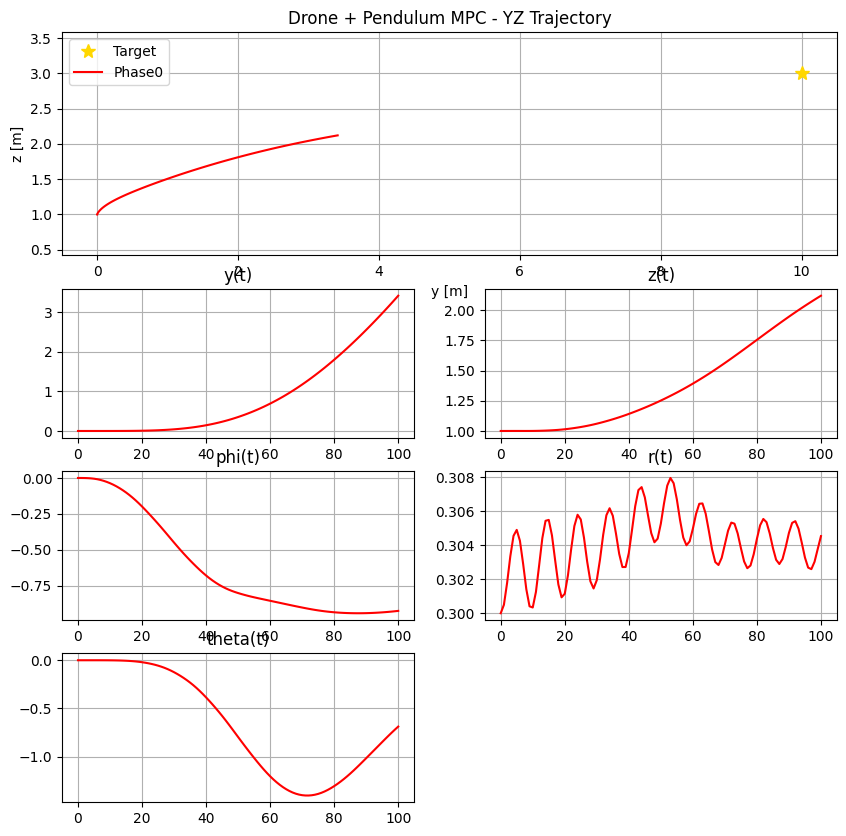

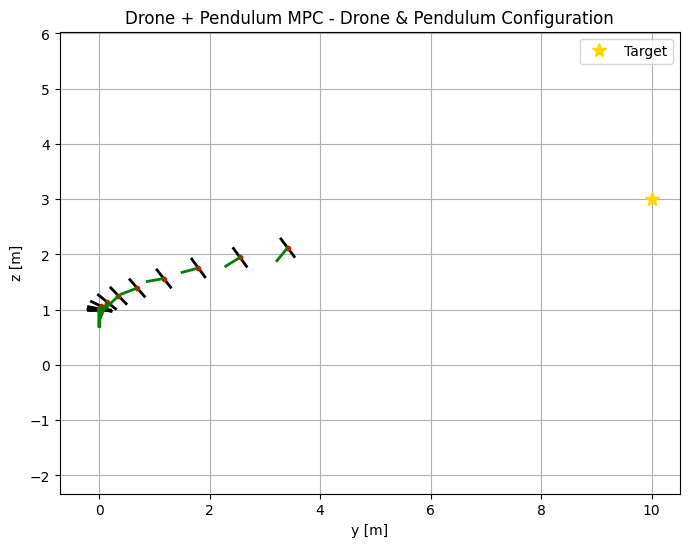

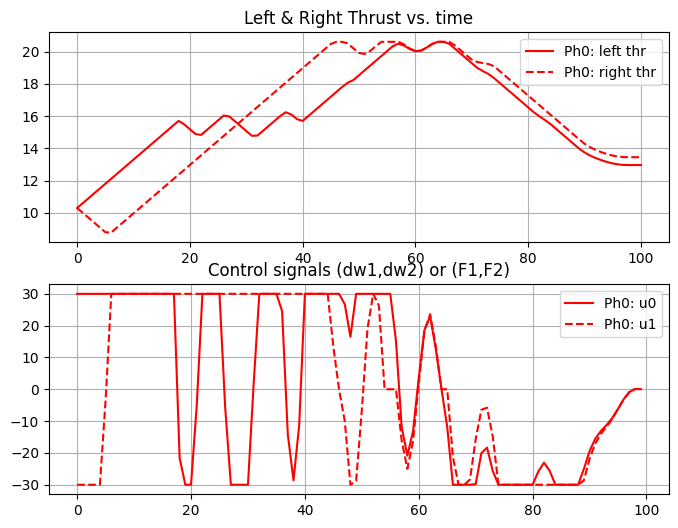

In [2]:
from plotting_utils_drone import plot_drone_mpc_solution

x_traj, u_traj = mpc.get_planned_trajectory()

plot_drone_mpc_solution(
    mpc=mpc, 
    reference_xy=pos_ref,
    open_loop_plan=x_traj,
    u_traj=u_traj,
    step_pose=10
)

Next, let's simulate in closed loop and see if the taken trajectories are sensible.

# it	stat		eq		ineq		comp		qp_stat	qp_iter	alpha
0	9.385742e-07	8.060219e-13	0.000000e+00	6.000000e-15	0	0	1.000000e+00
Optimal Solution found! Converged to KKT point.
# it	stat		eq		ineq		comp		qp_stat	qp_iter	alpha
0	9.385742e-07	8.060219e-13	3.000000e-01	7.207458e-01	0	0	1.000000e+00
1	2.135809e-01	2.143796e-03	0.000000e+00	6.000000e-15	0	21	1.000000e+00
2	5.373974e-03	5.793510e-05	0.000000e+00	6.000000e-15	0	15	1.000000e+00
3	1.481043e-03	1.765119e-05	0.000000e+00	6.000000e-15	0	18	1.000000e+00
4	3.456830e-04	3.583393e-06	0.000000e+00	6.000000e-15	0	20	1.000000e+00
5	2.798094e-04	1.793763e-06	0.000000e+00	6.000000e-15	0	16	1.000000e+00
6	1.730177e-04	4.008137e-07	0.000000e+00	6.000000e-15	0	17	1.000000e+00
7	1.417732e-04	2.762639e-07	0.000000e+00	6.000000e-15	0	31	1.000000e+00
8	1.145370e-04	1.969219e-07	0.000000e+00	6.000000e-15	0	17	1.000000e+00
9	9.243682e-05	1.170628e-07	0.000000e+00	6.000000e-15	0	14	1.000000e+00
# it	stat		eq		ineq		comp		qp_stat	qp_iter	alpha
10	7.466829e-05

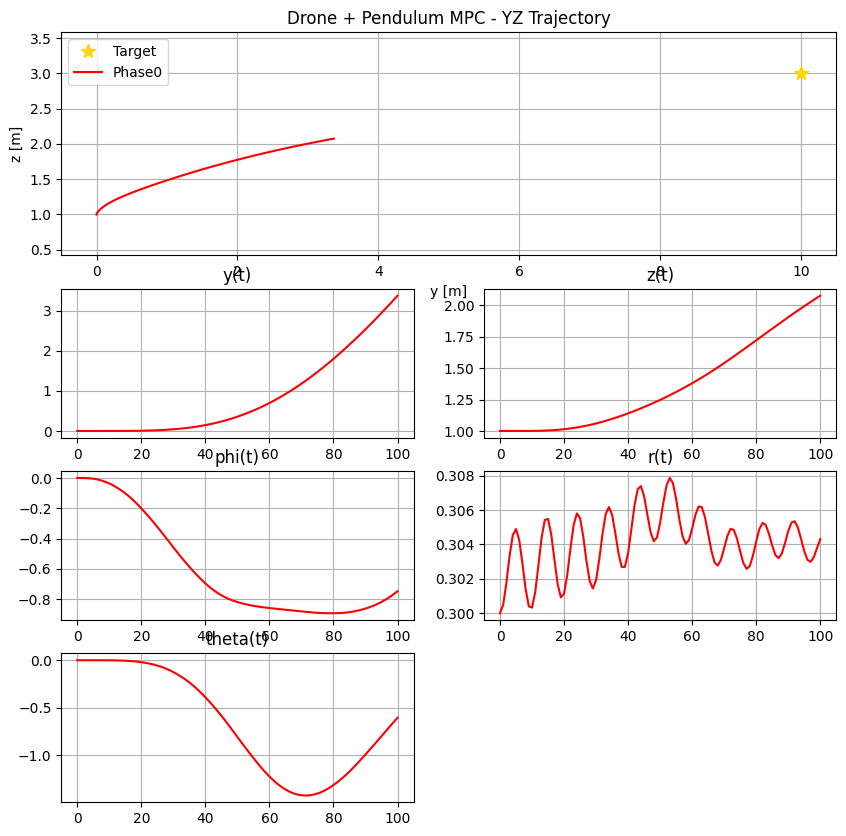

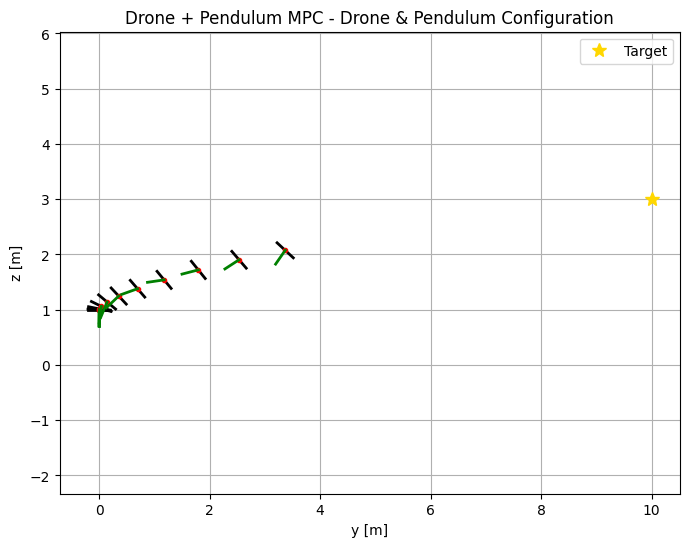

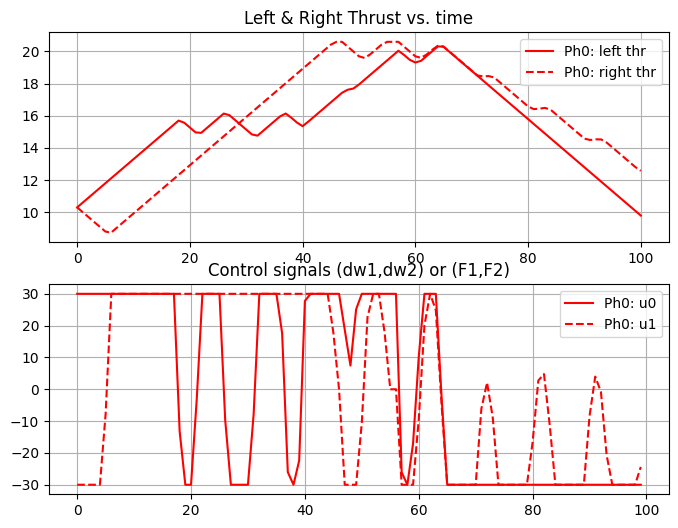

In [3]:
from utils_drone import simulate_closed_loop_drone

duration = 1

x_traj, u_traj, _, _ = simulate_closed_loop_drone(
    x0, 
    mpc, 
    duration, 
    sigma_noise=0.0,  
    sim_solver=None, 
    control_step=1
)

plot_drone_mpc_solution(
    mpc=mpc, 
    reference_xy=pos_ref,
    closed_loop_traj=x_traj,
    u_traj=u_traj,
    step_pose=10
)